In [1]:
# Libraries
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.mixture import GaussianMixture
import numpy as np
import statsmodels.api as sm
from scipy.stats import poisson, nbinom
from sklearn.model_selection import train_test_split
import statsmodels.gam.api as smg
import statsmodels.api as sm
from pygam import LogisticGAM, f
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment

### Load Data

In [2]:
white = pd.read_csv("../data/winequality-white.csv", sep=';')
red = pd.read_csv("../data/winequality-red.csv", sep=';')

In [3]:
white.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         4898 non-null   float64
 1   volatile acidity      4898 non-null   float64
 2   citric acid           4898 non-null   float64
 3   residual sugar        4898 non-null   float64
 4   chlorides             4898 non-null   float64
 5   free sulfur dioxide   4898 non-null   float64
 6   total sulfur dioxide  4898 non-null   float64
 7   density               4898 non-null   float64
 8   pH                    4898 non-null   float64
 9   sulphates             4898 non-null   float64
 10  alcohol               4898 non-null   float64
 11  quality               4898 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 459.3 KB


In [4]:
red.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


### Shapiro-Wilk test

In [5]:
from scipy.stats import shapiro

# test normal distribution
for column in white.columns[:-1]: 
    stat, p = shapiro(white[column])
    print(f'White-{column}: Statistics={stat:.3f}, p-value={p:.3f}')

print('\n')

for column in red.columns[:-1]: 
    stat, p = shapiro(red[column])
    print(f'Red-{column}: Statistics={stat:.3f}, p-value={p:.3f}')

White-fixed acidity: Statistics=0.977, p-value=0.000
White-volatile acidity: Statistics=0.905, p-value=0.000
White-citric acid: Statistics=0.922, p-value=0.000
White-residual sugar: Statistics=0.885, p-value=0.000
White-chlorides: Statistics=0.591, p-value=0.000
White-free sulfur dioxide: Statistics=0.942, p-value=0.000
White-total sulfur dioxide: Statistics=0.989, p-value=0.000
White-density: Statistics=0.955, p-value=0.000
White-pH: Statistics=0.988, p-value=0.000
White-sulphates: Statistics=0.952, p-value=0.000
White-alcohol: Statistics=0.955, p-value=0.000


Red-fixed acidity: Statistics=0.942, p-value=0.000
Red-volatile acidity: Statistics=0.974, p-value=0.000
Red-citric acid: Statistics=0.955, p-value=0.000
Red-residual sugar: Statistics=0.566, p-value=0.000
Red-chlorides: Statistics=0.484, p-value=0.000
Red-free sulfur dioxide: Statistics=0.902, p-value=0.000
Red-total sulfur dioxide: Statistics=0.873, p-value=0.000
Red-density: Statistics=0.991, p-value=0.000
Red-pH: Statistics

Reject H0, features doesn't follow normal distribution.

### Correlation Analysis (Spearman)
Here use Spearman because its assumptions doesn't include normal distribution.

In [8]:
white_corr = white.corr(method='spearman')['quality'].sort_values(ascending=False)
print("White Wine Correlation with Quality:")
print(white_corr)

red_corr = red.corr(method='spearman')['quality'].sort_values(ascending=False)
print("\nRed Wine Correlation with Quality:")
print(red_corr)

| Feature                | White Wine            | Red Wine              | Comparison Analysis                  |
|------------------------|-----------------------|-----------------------|--------------------------------------|
| **alcohol**            | 0.440 (positive)      | 0.479 (positive)      | Equally strong positive correlation  |
| **volatile acidity**   | -0.197 (negative)     | -0.381 (negative)     | Equally strong negative correlation  |
| **total sulfur dioxide**| -0.197 (negative)    | -0.197 (negative)     | Equally strong negative correlation  |
| **sulphates**          | 0.033 (positive)      | 0.377 (positive)      | Positive but weaker in white wine    |
| **citric acid**        | 0.018 (positive)      | 0.213 (positive)      | Positive but weaker in white wine    |
| **chlorides**          | -0.314 (negative)     | -0.190 (negative)     | Negative but weaker in red wine      |
| **density**            | -0.348 (negative)     | -0.177 (negative)     | Negative but weaker in red wine      |
| **fixed acidity**      | -0.084 (negative)     | 0.114 (positive)      | Opposite direction                   |
| **residual sugar**     | -0.082 (negative)     | 0.032 (positive)      | Opposite direction                   |
| **pH**                 | 0.109 (positive)      | -0.044 (negative)     | Opposite direction                   |
| **free sulfur dioxide**| 0.024 (positive)      | -0.057 (negative)     | Opposite direction                   |

So according to the result, we probably need to build models with different coefficients for red and white.

### Hypothesis Testing
Here use Mann-Whitney U test because its assumptions doesn't include normal distribution.

In [4]:
# Mann-Whitney U test
results = []
for column in red.columns[:-1]: 
    test_stat, p_value = stats.mannwhitneyu(red[column], white[column], alternative='two-sided')

    # Store the results
    results.append({
        'Property': column,
        'Red Mean': red[column].mean(),
        'Red Median': red[column].median(),
        'White Mean': white[column].mean(),
        'White Median': white[column].median(),
        'Test Statistic': test_stat,
        'P-value': p_value
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


                Property   Red Mean  Red Median  White Mean  White Median  \
0          fixed acidity   8.319637     7.90000    6.854788       6.80000   
1       volatile acidity   0.527821     0.52000    0.278241       0.26000   
2            citric acid   0.270976     0.26000    0.334192       0.32000   
3         residual sugar   2.538806     2.20000    6.391415       5.20000   
4              chlorides   0.087467     0.07900    0.045772       0.04300   
5    free sulfur dioxide  15.874922    14.00000   35.308085      34.00000   
6   total sulfur dioxide  46.467792    38.00000  138.360657     134.00000   
7                density   0.996747     0.99675    0.994027       0.99374   
8                     pH   3.311113     3.31000    3.188267       3.18000   
9              sulphates   0.658149     0.62000    0.489847       0.47000   
10               alcohol  10.422983    10.20000   10.514267      10.40000   

    Test Statistic        P-value  
0        6138507.0  1.438930e-255  
1  

A small p-value (typically < 0.05) suggests that the difference between the groups is statistically significant.

Based on the results above, there are highly significant differences in most of the physicochemical properties between red and white wines, except for alcohol content, which does not show a significant difference.

### Generalized Linear Models (GLMs)

White Wine

Poisson Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3907
Model Family:                 Poisson   Df Model:                           10
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -7294.4
Date:                Sat, 22 Mar 2025   Deviance:                       384.68
Time:                        17:54:09   Pearson chi2:                     383.
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03565
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
cons

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


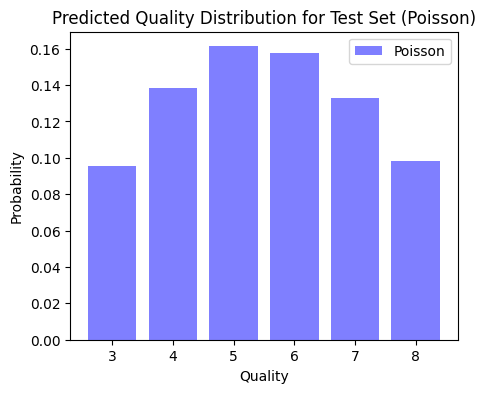

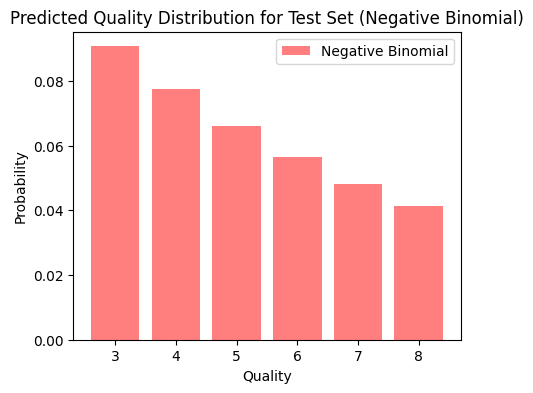

In [7]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
X = sm.add_constant(X) # add constant
y = white['quality'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Poission
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print("Poisson Regression Results:")
print(poisson_results.summary())

# NegativeBinomial
nb_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()


# Predict
poisson_predicted_means = poisson_results.predict(X_test) 
nb_predicted_means = nb_results.predict(X_test) 

x = range(int(y_test.min()), int(y_test.max()) + 1)

# pmf
poisson_pmf = np.mean([poisson(mu=mean).pmf(x) for mean in poisson_predicted_means], axis=0)

alpha = nb_results.scale
p = 1 / (1 + alpha * nb_predicted_means)
n = nb_predicted_means * p / (1 - p)
nb_pmf = np.mean([nbinom(n=n_i, p=p_i).pmf(x) for n_i, p_i in zip(n, p)], axis=0)

plt.figure(figsize=(5, 4))
plt.bar(x, poisson_pmf, color='blue', alpha=0.5, label='Poisson')
plt.xlabel('Quality')
plt.ylabel('Probability')
plt.title('Predicted Quality Distribution for Test Set (Poisson)')
plt.legend()
plt.show()

plt.figure(figsize=(5, 4))
plt.bar(x, nb_pmf, color='red', alpha=0.5, label='Negative Binomial')
plt.xlabel('Quality')
plt.ylabel('Probability')
plt.title('Predicted Quality Distribution for Test Set (Negative Binomial)')
plt.legend()
plt.show()

In [4]:
print("GLM (Poisson Regression) AIC:", poisson_results.aic)
print("GLM (Negative Binomial Regression) AIC:", nb_results.aic)

GLM (Poisson Regression) AIC: 14610.785709938742
GLM (Negative Binomial Regression) AIC: 22339.933575905292


In [8]:
poisson_predicted_rounded = np.round(poisson_predicted_means).astype(int)
nb_predicted_rounded = np.round(nb_predicted_means).astype(int)

poisson_misclassified = np.sum(poisson_predicted_rounded != y_test)
nb_misclassified = np.sum(nb_predicted_rounded != y_test)

poisson_misclassification_rate = poisson_misclassified / len(y_test)
nb_misclassification_rate = nb_misclassified / len(y_test)

print("Poisson Misclassification Rate:", poisson_misclassification_rate)
print("Negative Binomial Misclassification Rate:", nb_misclassification_rate)

Poisson Misclassification Rate: 0.4969387755102041
Negative Binomial Misclassification Rate: 0.4928571428571429


red wine

Poisson Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1279
Model:                            GLM   Df Residuals:                     1267
Model Family:                 Poisson   Df Model:                           11
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2341.1
Date:                Fri, 21 Mar 2025   Deviance:                       97.339
Time:                        18:12:07   Pearson chi2:                     95.7
No. Iterations:                     4   Pseudo R-squ. (CS):            0.03911
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
cons

/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


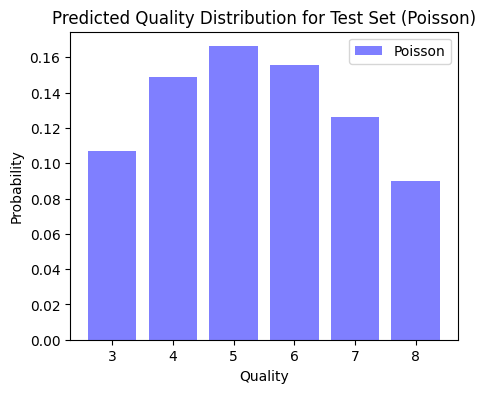

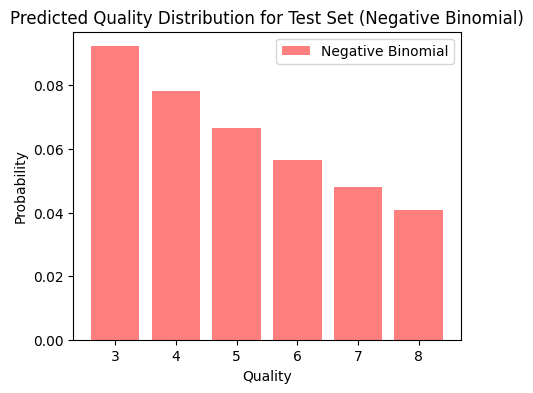

In [ ]:
X = red.drop(columns=['quality']) 
X = sm.add_constant(X) # add constant
y = red['quality'] 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Poission
poisson_model = sm.GLM(y_train, X_train, family=sm.families.Poisson())
poisson_results = poisson_model.fit()
print("Poisson Regression Results:")
print(poisson_results.summary())

# NegativeBinomial
nb_model = sm.GLM(y_train, X_train, family=sm.families.NegativeBinomial())
nb_results = nb_model.fit()


# Predict
poisson_predicted_means = poisson_results.predict(X_test) 
nb_predicted_means = nb_results.predict(X_test) 

x = range(int(y_test.min()), int(y_test.max()) + 1)

# pmf
poisson_pmf = np.mean([poisson(mu=mean).pmf(x) for mean in poisson_predicted_means], axis=0)

alpha = nb_results.scale
p = 1 / (1 + alpha * nb_predicted_means)
n = nb_predicted_means * p / (1 - p)
nb_pmf = np.mean([nbinom(n=n_i, p=p_i).pmf(x) for n_i, p_i in zip(n, p)], axis=0)

plt.figure(figsize=(5, 4))
plt.bar(x, poisson_pmf, color='blue', alpha=0.5, label='Poisson')
plt.xlabel('Quality')
plt.ylabel('Probability')
plt.title('Predicted Quality Distribution for Test Set (Poisson)')
plt.legend()
plt.show()

plt.figure(figsize=(5, 4))
plt.bar(x, nb_pmf, color='red', alpha=0.5, label='Negative Binomial')
plt.xlabel('Quality')
plt.ylabel('Probability')
plt.title('Predicted Quality Distribution for Test Set (Negative Binomial)')
plt.legend()
plt.show()

In [6]:
print("GLM (Poisson Regression) AIC:", poisson_results.aic)
print("GLM (Negative Binomial Regression) AIC:", nb_results.aic)

GLM (Poisson Regression) AIC: 4706.131164327639
GLM (Negative Binomial Regression) AIC: 7207.128306806824


In [7]:
poisson_predicted_rounded = np.round(poisson_predicted_means).astype(int)
nb_predicted_rounded = np.round(nb_predicted_means).astype(int)

poisson_misclassified = np.sum(poisson_predicted_rounded != y_test)
nb_misclassified = np.sum(nb_predicted_rounded != y_test)

poisson_misclassification_rate = poisson_misclassified / len(y_test)
nb_misclassification_rate = nb_misclassified / len(y_test)

print("Poisson Misclassification Rate:", poisson_misclassification_rate)
print("Negative Binomial Misclassification Rate:", nb_misclassification_rate)

Poisson Misclassification Rate: 0.425
Negative Binomial Misclassification Rate: 0.41875


### Generalized Additive Models (GAMs) & Splines

White wine - Gamma

/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 3918
Model:                         GLMGam   Df Residuals:                  3877.00
Model Family:                   Gamma   Df Model:                        40.00
Link Function:           InversePower   Scale:                        0.015418
Method:                         PIRLS   Log-Likelihood:                -4286.4
Date:                Fri, 21 Mar 2025   Deviance:                       60.587
Time:                        18:12:40   Pearson chi2:                     59.8
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3989
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

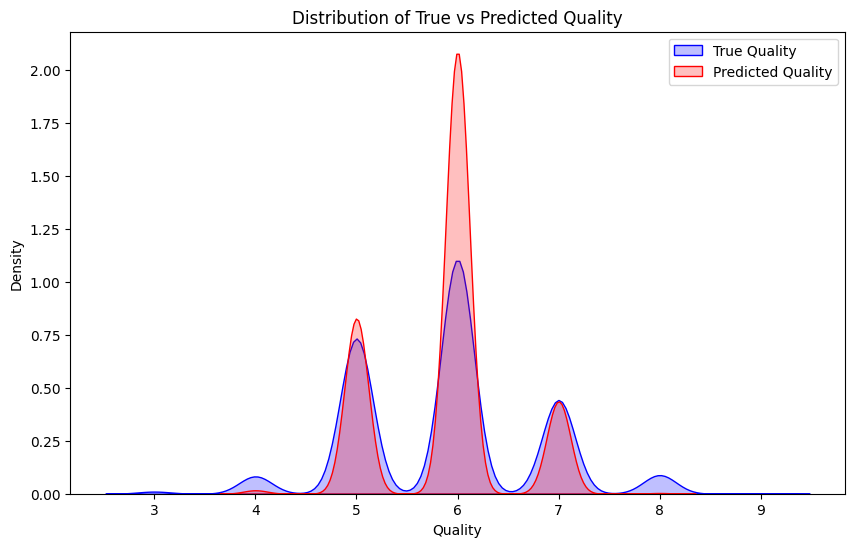

In [8]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bs = smg.BSplines(x=X_train, df = [5]*10, degree=[3]*10)
# print(bs)

exog = X_train
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=y_train, 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.Gamma()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())


y_test_pred = res_bs.predict()
y_pred_rounded = np.round(y_test_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [9]:
aic_value = res_bs.aic
print(f"GAM (Gamma) AIC: {aic_value}")

GAM (Gamma) AIC: 8654.793046697769


In [10]:
misclassified = np.sum(y_pred_rounded != y_train)
misclassification_rate = misclassified / len(y_train)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.46018376722817766


red wine - Gamma

/Users/zhengqijia/Library/Python/3.8/lib/python/site-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1279
Model:                         GLMGam   Df Residuals:                  1234.00
Model Family:                   Gamma   Df Model:                        44.00
Link Function:           InversePower   Scale:                        0.012664
Method:                         PIRLS   Log-Likelihood:                -1218.0
Date:                Fri, 21 Mar 2025   Deviance:                       16.206
Time:                        18:14:04   Pearson chi2:                     15.6
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4802
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

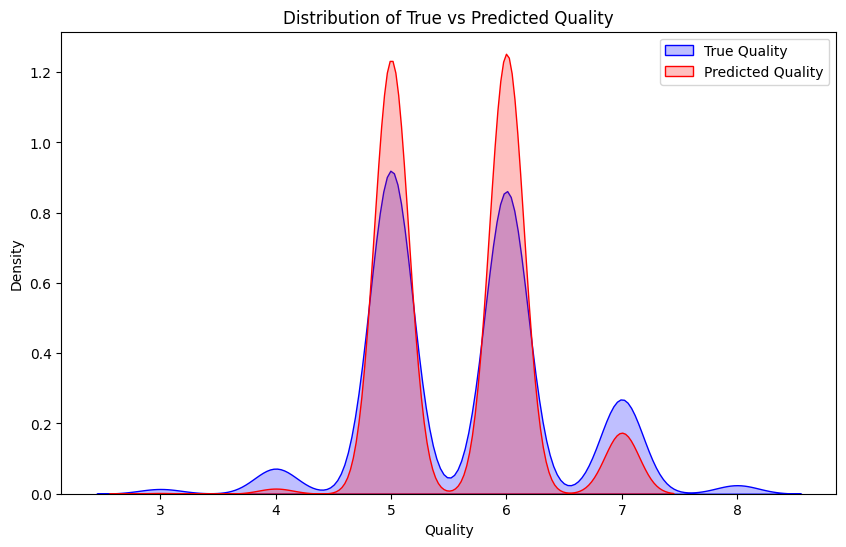

In [12]:
X = red.drop(columns=['quality'])
y = red['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bs = smg.BSplines(x=X_train, df = [5]*11, degree=[3]*11)
# print(bs)

exog = X_train
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=y_train, 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.Gamma()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())


y_test_pred = res_bs.predict()
y_pred_rounded = np.round(y_test_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [13]:
aic_value = res_bs.aic
print(f"GAM (Gamma) AIC: {aic_value}")

GAM (Gamma) AIC: 2526.0284774746133


In [14]:
misclassified = np.sum(y_pred_rounded != y_train)
misclassification_rate = misclassified / len(y_train)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.3893666927286943


🍸 white wine - Gaussian

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 4898
Model:                         GLMGam   Df Residuals:                  4857.00
Model Family:                Gaussian   Df Model:                        40.00
Link Function:               Identity   Scale:                         0.52393
Method:                         PIRLS   Log-Likelihood:                -5346.3
Date:                Fri, 21 Mar 2025   Deviance:                       2544.7
Time:                        18:16:55   Pearson chi2:                 2.54e+03
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3966
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

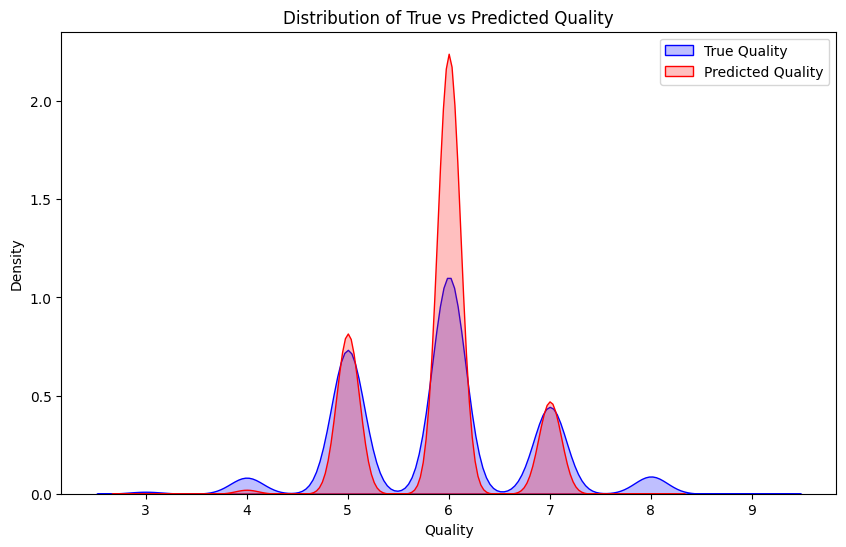

In [18]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']

bs = smg.BSplines(x=X, df = [5]*10, degree=[3]*10)
# print(bs)

exog = X
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=white['quality'], 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.Gaussian()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())

y_pred = res_bs.predict()
y_pred_rounded = np.round(y_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [19]:
aic_value = res_bs.aic
print(f"GAM (Gaussian) AIC: {aic_value}")

GAM (Gaussian) AIC: 10774.666337221466


In [20]:
misclassification_rate = np.sum(y_pred_rounded != y) / len(y)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.4667211106574112


red wine🍷 - Gaussian

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1599
Model:                         GLMGam   Df Residuals:                  1554.00
Model Family:                Gaussian   Df Model:                        44.00
Link Function:               Identity   Scale:                         0.39535
Method:                         PIRLS   Log-Likelihood:                -1504.1
Date:                Fri, 21 Mar 2025   Deviance:                       614.37
Time:                        18:30:13   Pearson chi2:                     614.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.4919
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

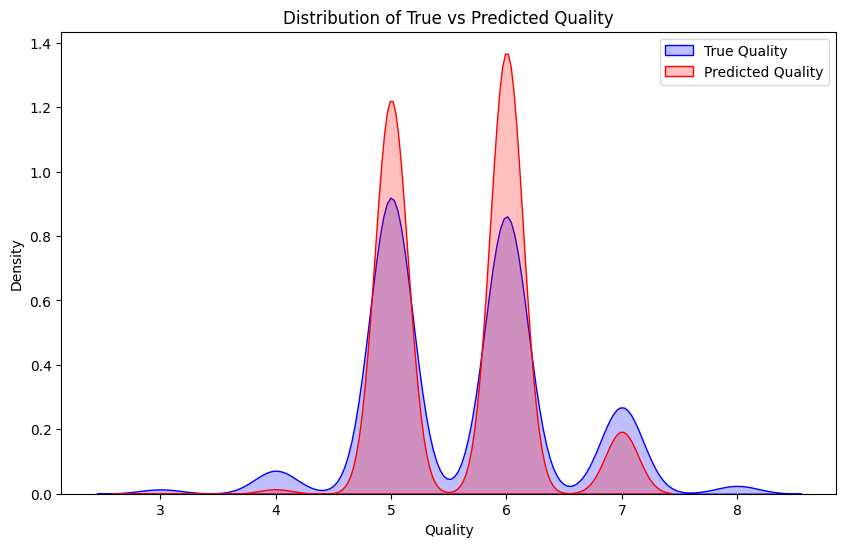

In [21]:
X = red.drop(columns=['quality'])
y = red['quality']

bs = smg.BSplines(x=X, df = [5]*11, degree=[3]*11)
# print(bs)

exog = X
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=red['quality'], 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.Gaussian()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())

y_pred = res_bs.predict()
y_pred_rounded = np.round(y_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [22]:
aic_value = res_bs.aic
print(f"GAM (Gaussian) AIC: {aic_value}")

GAM (Gaussian) AIC: 3098.2758001109783


In [23]:
misclassification_rate = np.sum(y_pred_rounded != y) / len(y)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.39399624765478425


white wine 🍸 - InverseGaussian

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 4898
Model:                         GLMGam   Df Residuals:                  4857.00
Model Family:         InverseGaussian   Df Model:                        40.00
Link Function:         InverseSquared   Scale:                       0.0026691
Method:                         PIRLS   Log-Likelihood:                -5451.1
Date:                Fri, 21 Mar 2025   Deviance:                       13.533
Time:                        18:38:09   Pearson chi2:                     13.0
No. Iterations:                     6   Pseudo R-squ. (CS):             0.3905
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

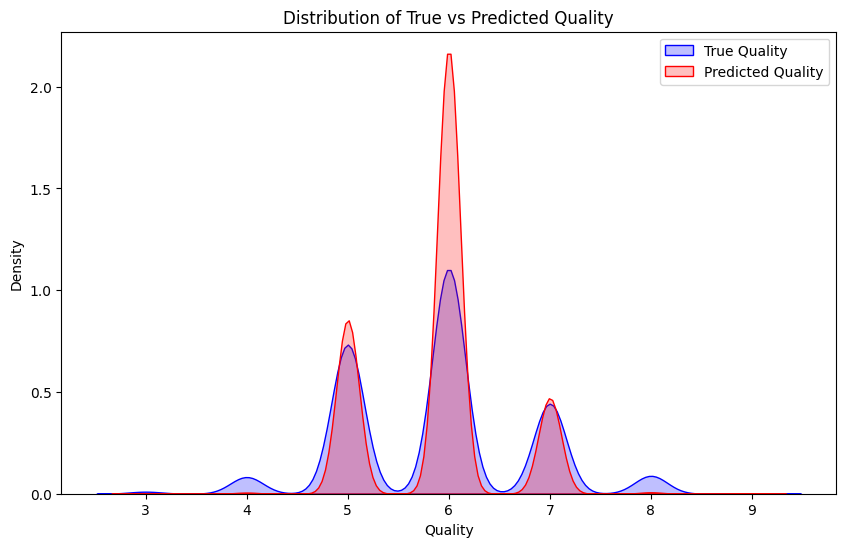

In [37]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']

bs = smg.BSplines(x=X, df = [5]*10, degree=[3]*10)
# print(bs)

exog = X
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=white['quality'], 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.InverseGaussian()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())

y_pred = res_bs.predict()
y_pred_rounded = np.round(y_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [38]:
aic_value = res_bs.aic
print(f"GAM (InverseGaussian) AIC: {aic_value}")

GAM (InverseGaussian) AIC: 10984.101991339941


In [39]:
misclassification_rate = np.sum(y_pred_rounded != y) / len(y)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.472029399755002


red wine🍷 - InverseGaussian

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1599
Model:                         GLMGam   Df Residuals:                  1554.00
Model Family:         InverseGaussian   Df Model:                        44.00
Link Function:         InverseSquared   Scale:                       0.0022323
Method:                         PIRLS   Log-Likelihood:                -1545.8
Date:                Fri, 21 Mar 2025   Deviance:                       3.7266
Time:                        18:38:18   Pearson chi2:                     3.47
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4834
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

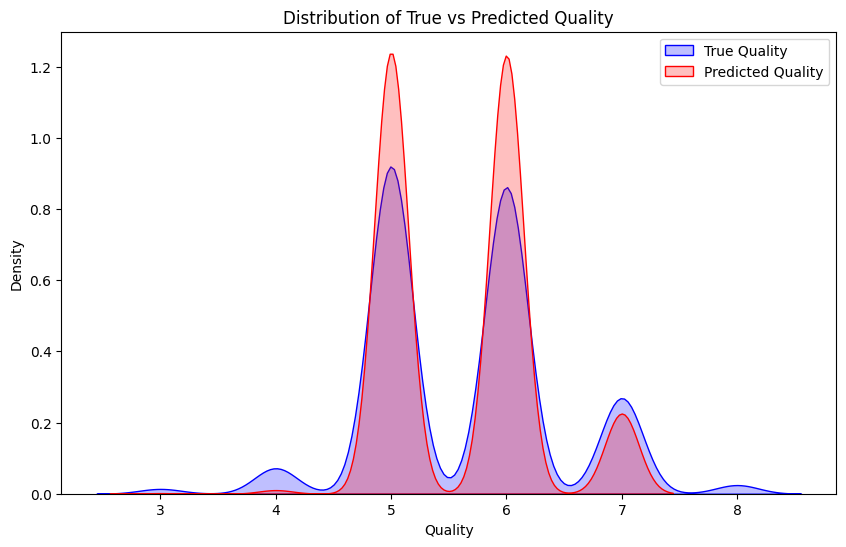

In [40]:
X = red.drop(columns=['quality'])
y = red['quality']

bs = smg.BSplines(x=X, df = [5]*11, degree=[3]*11)
# print(bs)

exog = X
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=red['quality'], 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.InverseGaussian()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())

y_pred = res_bs.predict()
y_pred_rounded = np.round(y_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [41]:
aic_value = res_bs.aic
print(f"GAM (InverseGaussian) AIC: {aic_value}")

GAM (InverseGaussian) AIC: 3181.587734311352


In [42]:
misclassification_rate = np.sum(y_pred_rounded != y) / len(y)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.3902439024390244


🍸 white wine - Tweedie

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 4898
Model:                         GLMGam   Df Residuals:                  4857.00
Model Family:                 Tweedie   Df Model:                        40.00
Link Function:                    Log   Scale:                        0.089301
Method:                         PIRLS   Log-Likelihood:            -1.0189e+05
Date:                Fri, 21 Mar 2025   Deviance:                       435.16
Time:                        18:38:34   Pearson chi2:                     434.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3972
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

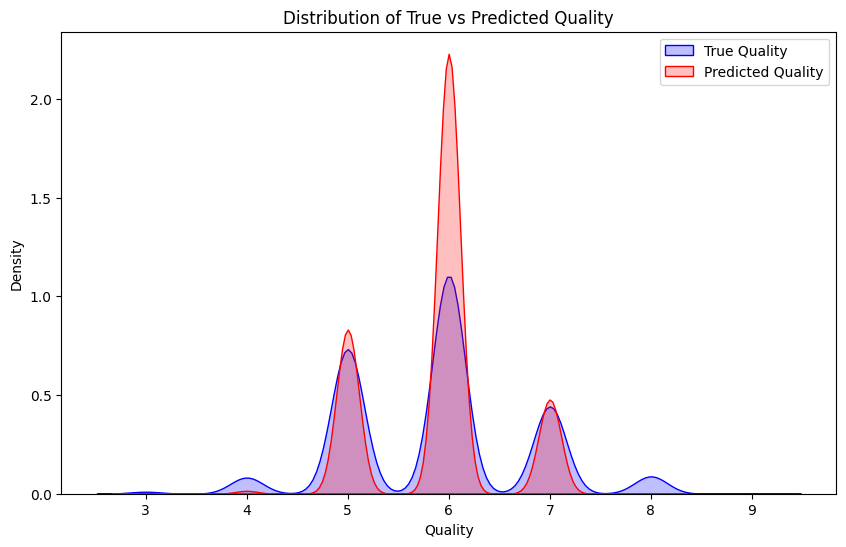

In [43]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']

bs = smg.BSplines(x=X, df = [5]*10, degree=[3]*10)
# print(bs)

exog = X
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=white['quality'], 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.Tweedie()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())

y_pred = res_bs.predict()
y_pred_rounded = np.round(y_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [44]:
aic_value = res_bs.aic
print(f"GAM (Tweedie) AIC: {aic_value}")

GAM (Tweedie) AIC: 203860.75061774734


In [45]:
misclassification_rate = np.sum(y_pred_rounded != y) / len(y)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.4685585953450388


red wine🍷 - Tweedie

                 Generalized Linear Model Regression Results                  
Dep. Variable:                quality   No. Observations:                 1599
Model:                         GLMGam   Df Residuals:                  1554.00
Model Family:                 Tweedie   Df Model:                        44.00
Link Function:                    Log   Scale:                        0.069682
Method:                         PIRLS   Log-Likelihood:                -41941.
Date:                Fri, 21 Mar 2025   Deviance:                       109.69
Time:                        18:38:45   Pearson chi2:                     108.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.4920
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

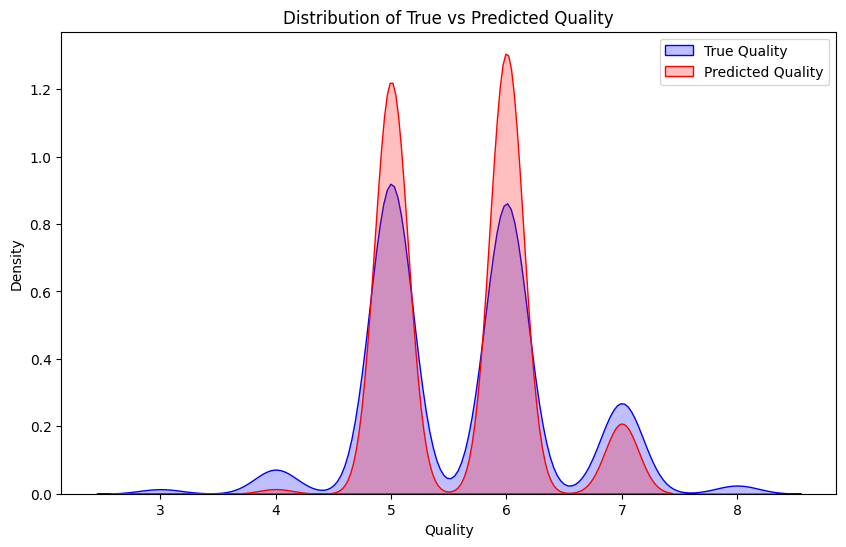

In [46]:
X = red.drop(columns=['quality'])
y = red['quality']

bs = smg.BSplines(x=X, df = [5]*11, degree=[3]*11)
# print(bs)

exog = X
exog = sm.add_constant(exog)

gam_bs = smg.GLMGam(endog=red['quality'], 
                    exog=exog, 
                    smoother=bs, 
                    family=sm.families.Tweedie()
                    )

res_bs = gam_bs.fit(maxiter=5000)
print(res_bs.summary())

y_pred = res_bs.predict()
y_pred_rounded = np.round(y_pred).astype(int)

plt.figure(figsize=(10, 6))
sns.kdeplot(y, color='blue', label='True Quality', fill=True)
sns.kdeplot(y_pred_rounded, color='red', label='Predicted Quality', fill=True)
plt.title('Distribution of True vs Predicted Quality')
plt.xlabel('Quality')
plt.ylabel('Density')
plt.legend()
plt.show()

In [47]:
aic_value = res_bs.aic
print(f"GAM (Tweedie) AIC: {aic_value}")

GAM (Tweedie) AIC: 83971.4411744414


In [48]:
misclassification_rate = np.sum(y_pred_rounded != y) / len(y)
print(f"Misclassification Rate: {misclassification_rate}")

Misclassification Rate: 0.3896185115697311


🍸 white wine - LogisticGAM

In [49]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classes = np.unique(y)

# store LogisticGAM model for each quality
models = {}

# turn into multiple binary classification:
for cls in classes:
    y_binary = (y == cls).astype(int)
    gam_log = LogisticGAM(
        f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9)  # all features
    )
    gam_log.fit(X, y_binary)
    models[cls] = gam_log

# this cell takes about 5min

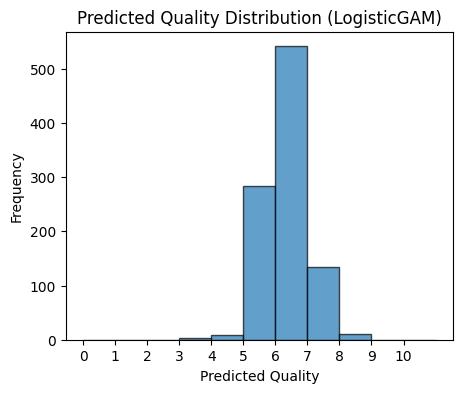

In [50]:
# predict
y_pred_proba = np.zeros((len(X_test), len(classes)))
for i, cls in enumerate(classes):
    y_pred_proba[:, i] = models[cls].predict_proba(X_test)

# assignment quality with the largest pro
y_pred = classes[np.argmax(y_pred_proba, axis=1)]

plt.figure(figsize=(5, 4))
plt.hist(y_pred, bins=range(0, 12), edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Quality')
plt.ylabel('Frequency')
plt.title('Predicted Quality Distribution (LogisticGAM)')
plt.xticks(range(0, 11))
plt.show()

In [ ]:
total_log_likelihood = 0
for cls in classes:
    total_log_likelihood += models[cls].statistics_['loglikelihood']

total_params = 0
for cls in classes:
    total_params += models[cls].statistics_['edof']

aic_values = {}
aic = 2 * total_params - 2 * total_log_likelihood
print("GAM (Logistic) AIC:", aic)

misclassification_rate = np.mean(y_pred != y_test)
print("Misclassification Rate:", misclassification_rate)


GAM (Logistic) AIC: 18025.388837426148
Misclassification Rate: 0.3408163265306122


red wine🍷 - LogisticGAM

In [52]:
X = red.drop(columns=['quality']) 
y = red['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

classes = np.unique(y)

# store LogisticGAM model for each quality
models = {}

# turn into multiple binary classification:
for cls in classes:
    y_binary = (y == cls).astype(int)
    gam_log = LogisticGAM(
        f(0) + f(1) + f(2) + f(3) + f(4) + f(5) + f(6) + f(7) + f(8) + f(9) + f(10)  # all features
    )
    gam_log.fit(X, y_binary)
    models[cls] = gam_log

# this cell takes about 5min

did not converge


### Gaussian Mixture Models (GMMs)

Here not just put GMM for the whole dataframe (the model looks bad through this method)

so just do GMM for each features first...

🍸 white wine

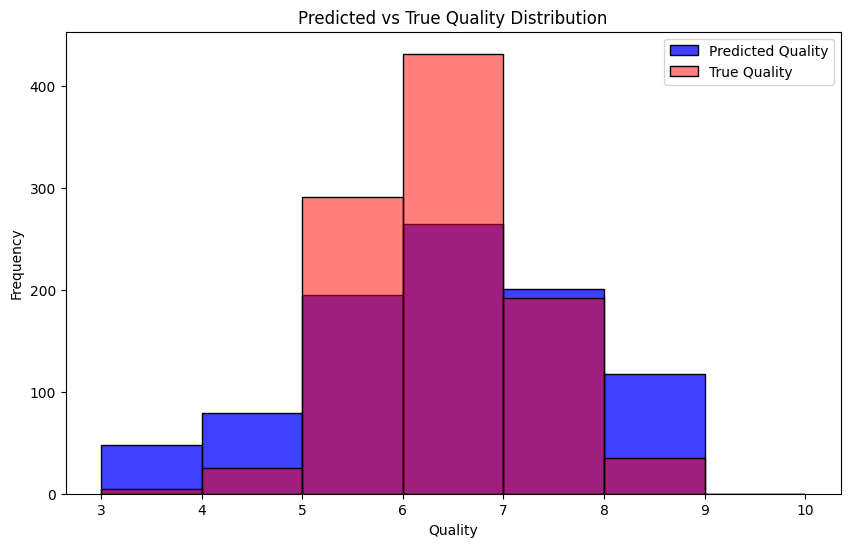

Misclassification Rate: 0.6969
GMM AIC: 23306.5083


In [17]:
X = white.drop(columns=['quality', 'residual sugar'])
y = white['quality'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

n_components = len(np.unique(y))
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_train)

y_test_pred = gmm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_test_pred)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

label_mapping = {pred: true for pred, true in zip(col_ind, row_ind)}
y_test_pred_mapped = np.array([label_mapping[pred] for pred in y_test_pred])

plt.figure(figsize=(10, 6))
sns.histplot(y_test_pred_mapped, bins=range(y.min(), y.max() + 2), kde=False, color='blue', label='Predicted Quality')
sns.histplot(y_test, bins=range(y.min(), y.max() + 2), kde=False, color='red', alpha=0.5, label='True Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Predicted vs True Quality Distribution')
plt.legend()
plt.show()

misclassification_rate = np.mean(y_test_pred_mapped != y_test)
print(f"Misclassification Rate: {misclassification_rate:.4f}")

aic = gmm.aic(X_test)
print(f"GMM AIC: {aic:.4f}")

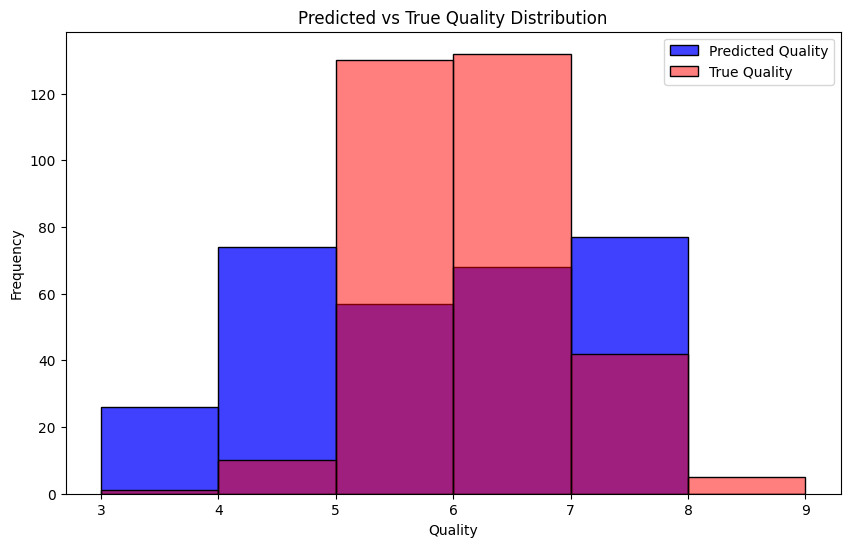

Misclassification Rate: 0.6906
GMM AIC: 7481.6989


In [18]:
X = red.drop(columns=['quality'])
y = red['quality'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

n_components = len(np.unique(y))
gmm = GaussianMixture(n_components=n_components, random_state=42)
gmm.fit(X_train)

y_test_pred = gmm.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_test_pred)
row_ind, col_ind = linear_sum_assignment(-conf_matrix)

label_mapping = {pred: true for pred, true in zip(col_ind, row_ind)}
y_test_pred_mapped = np.array([label_mapping[pred] for pred in y_test_pred])

plt.figure(figsize=(10, 6))
sns.histplot(y_test_pred_mapped, bins=range(y.min(), y.max() + 2), kde=False, color='blue', label='Predicted Quality')
sns.histplot(y_test, bins=range(y.min(), y.max() + 2), kde=False, color='red', alpha=0.5, label='True Quality')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Predicted vs True Quality Distribution')
plt.legend()
plt.show()

misclassification_rate = np.mean(y_test_pred_mapped != y_test)
print(f"Misclassification Rate: {misclassification_rate:.4f}")

aic = gmm.aic(X_test)
print(f"GMM AIC: {aic:.4f}")

### GMM & Random Forest
white wine

Test Accuracy: 0.6877551020408164


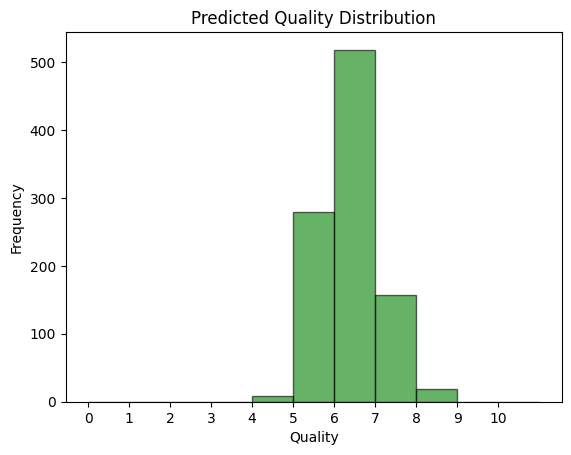

In [ ]:
X = white.drop(columns=['quality', 'residual sugar']) 
y = white['quality'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
columns = X.columns

gmm_models = {}
for i, column in enumerate(columns):
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm.fit(X_train[:, i].reshape(-1, 1))
    gmm_models[column] = gmm

def transform_with_gmm(X, gmm_models, columns):
    new_features = []
    for column, gmm in gmm_models.items():
        col_index = columns.get_loc(column)
        col_data = X[:, col_index].reshape(-1, 1)
        probs = gmm.predict_proba(col_data)
        new_features.append(probs)
    return np.hstack(new_features)

X_train_transformed = transform_with_gmm(X_train, gmm_models, columns)
X_test_transformed = transform_with_gmm(X_test, gmm_models, columns)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_transformed, y_train)

y_test_pred = clf.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

plt.hist(y_test_pred, bins=range(12), density=False, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Predicted Quality Distribution')
plt.xticks(range(11))  
plt.show()

In [24]:
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

misclassification_rate = 1 - accuracy
print("Misclassification Rate:", misclassification_rate)

Accuracy: 0.6877551020408164
Misclassification Rate: 0.31224489795918364


red wine

Test Accuracy: 0.675


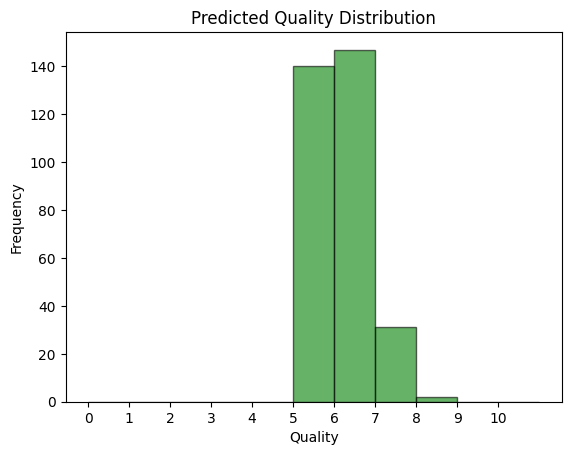

In [26]:
X = red.drop(columns=['quality']) 
y = red['quality'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
columns = X.columns

gmm_models = {}
for i, column in enumerate(columns):
    gmm = GaussianMixture(n_components=3, random_state=42)
    gmm.fit(X_train[:, i].reshape(-1, 1))
    gmm_models[column] = gmm

def transform_with_gmm(X, gmm_models, columns):
    new_features = []
    for column, gmm in gmm_models.items():
        col_index = columns.get_loc(column)
        col_data = X[:, col_index].reshape(-1, 1)
        probs = gmm.predict_proba(col_data)
        new_features.append(probs)
    return np.hstack(new_features)

X_train_transformed = transform_with_gmm(X_train, gmm_models, columns)
X_test_transformed = transform_with_gmm(X_test, gmm_models, columns)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_transformed, y_train)

y_test_pred = clf.predict(X_test_transformed)
accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", accuracy)

plt.hist(y_test_pred, bins=range(12), density=False, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Predicted Quality Distribution')
plt.xticks(range(11))  
plt.show()

In [27]:
accuracy = accuracy_score(y_test, y_test_pred)
print("Accuracy:", accuracy)

misclassification_rate = 1 - accuracy
print("Misclassification Rate:", misclassification_rate)

Accuracy: 0.675
Misclassification Rate: 0.32499999999999996


### Principal Component Analysis (PCA) & Random Forests

🍸 white wine

In [70]:
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# initialization PCA
pca = PCA(n_components=0.95)  # 95% of variance
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components after PCA: {pca.n_components_}")

# explainedn variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

Number of components after PCA: 8
Explained variance ratio: [0.27383842 0.15751441 0.11902836 0.09887417 0.09732562 0.08532436
 0.07001038 0.05076548]


RandomForestClassifier(random_state=42)

Random Forest Classifier Accuracy: 0.6949
Predicted quality distribution:
3    0.003267
4    0.030216
5    0.291752
6    0.470804
7    0.170886
8    0.032054
9    0.001021
Name: proportion, dtype: float64


([<matplotlib.axis.XTick at 0x13673d760>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

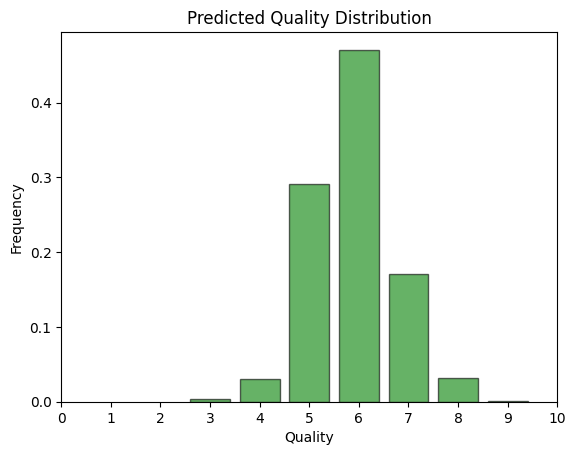

In [71]:
# accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")

# predict quality
y_pred_all = clf.predict(X_pca)  # predict for whole dataset

# analyze quality distribution
quality_distribution = pd.Series(y_pred_all).value_counts(normalize=True).sort_index()
print("Predicted quality distribution:")
print(quality_distribution)

plt.bar(quality_distribution.index, quality_distribution.values, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Predicted Quality Distribution')
plt.xticks(range(11))

In [72]:
y_test_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
misclassification_rate = 1 - accuracy

print("Test Accuracy:", accuracy)
print("Misclassification Rate:", misclassification_rate)

# aic seems not available for RandomForestClassifier

Test Accuracy: 0.6948979591836735
Misclassification Rate: 0.3051020408163265


red wine🍷

In [73]:
X = red.drop(columns=['quality'])
y = red['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# initialization PCA
pca = PCA(n_components=0.95)  # 95% of variance
X_pca = pca.fit_transform(X_scaled)
print(f"Number of components after PCA: {pca.n_components_}")

# explainedn variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained variance ratio:", explained_variance_ratio)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

Number of components after PCA: 9
Explained variance ratio: [0.28173931 0.1750827  0.1409585  0.11029387 0.08720837 0.05996439
 0.05307193 0.03845061 0.0313311 ]


RandomForestClassifier(random_state=42)

Random Forest Classifier Accuracy: 0.6719
Predicted quality distribution:
3    0.005629
4    0.026892
5    0.437774
6    0.404003
7    0.116948
8    0.008755
Name: proportion, dtype: float64


([<matplotlib.axis.XTick at 0x13dad8a30>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

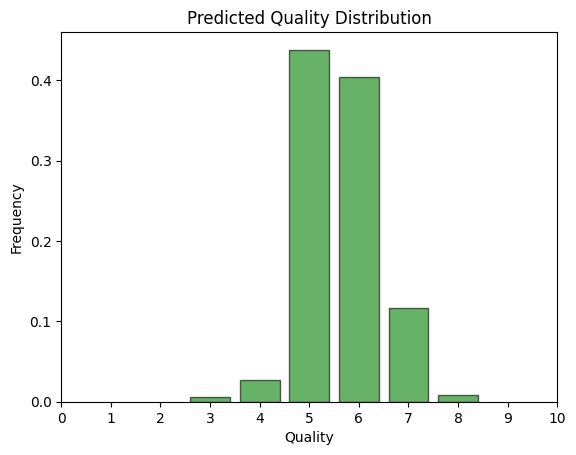

In [74]:
# accuracy
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")

# predict quality
y_pred_all = clf.predict(X_pca)  # predict for whole dataset

# analyze quality distribution
quality_distribution = pd.Series(y_pred_all).value_counts(normalize=True).sort_index()
print("Predicted quality distribution:")
print(quality_distribution)

plt.bar(quality_distribution.index, quality_distribution.values, alpha=0.6, color='g', edgecolor='black')
plt.xlabel('Quality')
plt.ylabel('Frequency')
plt.title('Predicted Quality Distribution')
plt.xticks(range(11))

In [75]:
y_test_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_test_pred)
misclassification_rate = 1 - accuracy

print("Test Accuracy:", accuracy)
print("Misclassification Rate:", misclassification_rate)

# aic seems not available for RandomForestClassifier

Test Accuracy: 0.671875
Misclassification Rate: 0.328125


### Random Forest on Original Data
white wine

In [9]:
# random forest for original data
X = white.drop(columns=['quality', 'residual sugar']) # residual sugar is highly correlated with density
y = white['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
clf_ori = RandomForestClassifier(n_estimators=100, random_state=42)
clf_ori.fit(X_train, y_train)

# accuracy
y_pred = clf_ori.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
misclassification_rate = 1 - accuracy

print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")

Random Forest Classifier Accuracy: 0.7112
Misclassification Rate: 0.2888


                Feature  Importance
9               alcohol    0.124404
6               density    0.117714
1      volatile acidity    0.109649
4   free sulfur dioxide    0.102600
5  total sulfur dioxide    0.101852
7                    pH    0.094217
3             chlorides    0.089954
2           citric acid    0.089604
8             sulphates    0.085943
0         fixed acidity    0.084063


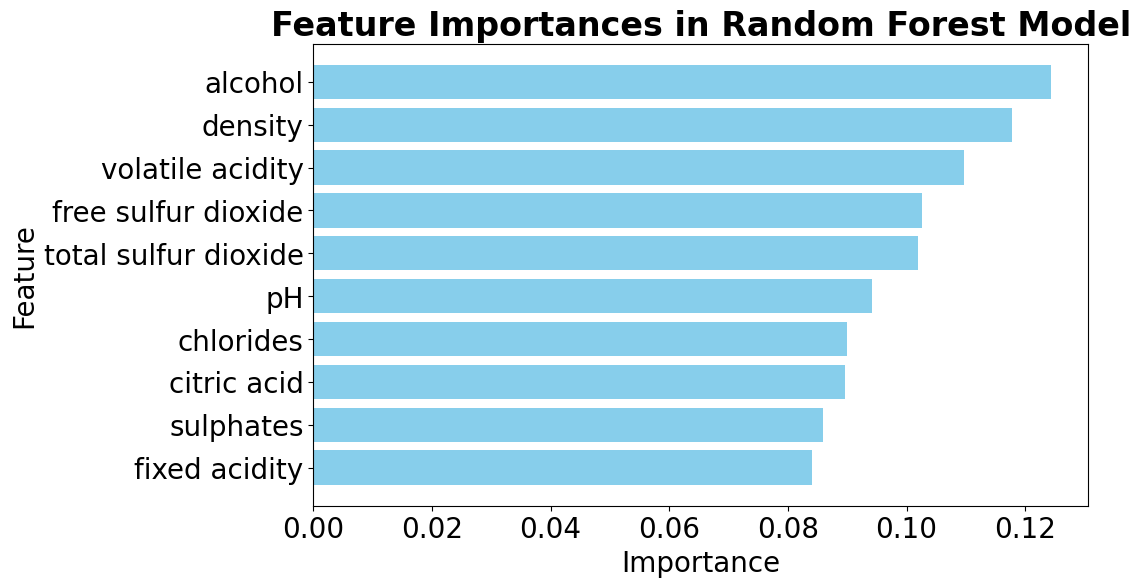

In [10]:
# Get feature importances
feature_importances = clf_ori.feature_importances_
feature_names = X.columns  

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importances in Random Forest Model', fontsize=24, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=20)  
plt.gca().invert_yaxis() 


red wine

In [11]:
# random forest for original data
X = red.drop(columns=['quality'])
y = red['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
clf_ori = RandomForestClassifier(n_estimators=100, random_state=42)
clf_ori.fit(X_train, y_train)

# accuracy
y_pred = clf_ori.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
misclassification_rate = 1 - accuracy

print(f"Random Forest Classifier Accuracy: {accuracy:.4f}")
print(f"Misclassification Rate: {misclassification_rate:.4f}")

Random Forest Classifier Accuracy: 0.6500
Misclassification Rate: 0.3500


                 Feature  Importance
10               alcohol    0.148560
9              sulphates    0.115580
6   total sulfur dioxide    0.102707
1       volatile acidity    0.097062
7                density    0.094776
4              chlorides    0.079761
8                     pH    0.076844
0          fixed acidity    0.074824
2            citric acid    0.071470
3         residual sugar    0.071449
5    free sulfur dioxide    0.066967


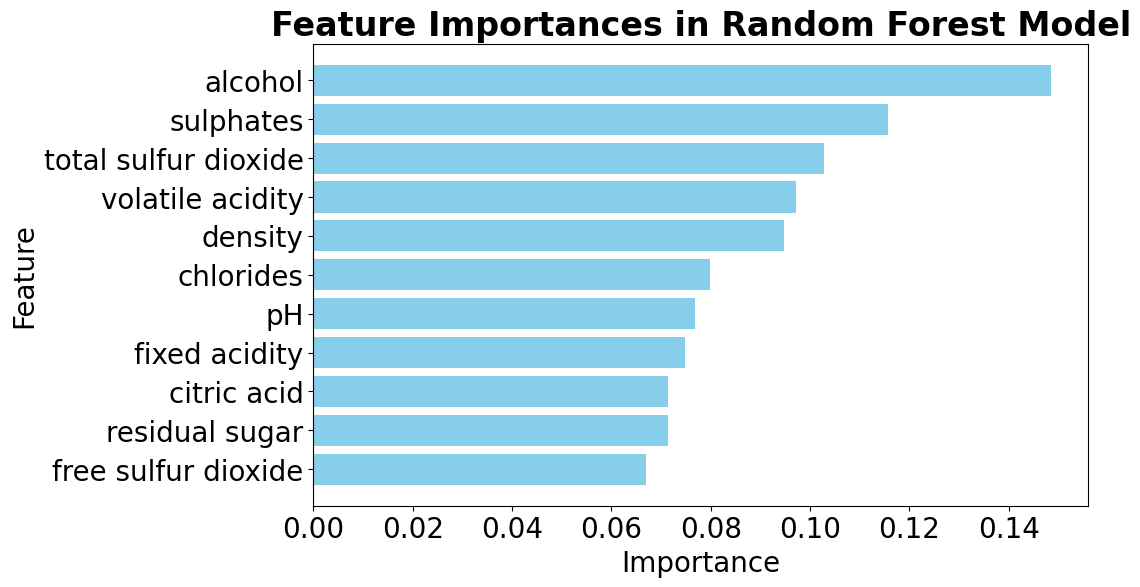

In [12]:
# Get feature importances
feature_importances = clf_ori.feature_importances_
feature_names = X.columns  

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print feature importances
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance', fontsize=20)
plt.ylabel('Feature', fontsize=20)
plt.title('Feature Importances in Random Forest Model', fontsize=24, fontweight='bold')
plt.tick_params(axis='both', which='major', labelsize=20)  
plt.gca().invert_yaxis() 